Import Library

In [6]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization, GaussianNoise
from keras.callbacks import EarlyStopping

Define the dataset paths and parameters

In [7]:
base_dir = r'C:\Users\User\Downloads\Acne Dataset'
train_data_dir = os.path.join(base_dir, 'train', 'dataset')
val_data_dir = os.path.join(base_dir, 'valid', 'dataset')
test_data_dir = os.path.join(base_dir, 'test', 'dataset')
annotations_train_file = os.path.join(base_dir, 'train', '_annotations.csv')
annotations_val_file = os.path.join(base_dir, 'valid', '_annotations.csv')
annotations_test_file = os.path.join(base_dir, 'test', '_annotations.csv')

Load Annotation

In [8]:
annotations_train = pd.read_csv(annotations_train_file)
annotations_val = pd.read_csv(annotations_val_file)

In [9]:
#Assign default batch size and check number of classes
batch_size = 32
num_classes = annotations_train['class'].nunique()

Preprocess the data

In [10]:
# Create image data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=annotations_train,
    directory=train_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Load and preprocess the validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=annotations_val,
    directory=val_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
)

Found 41040 validated image filenames belonging to 4 classes.
Found 2881 validated image filenames belonging to 4 classes.


Build the model

In [11]:
# Load the ResNet50 model (pretrained on ImageNet)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Let's fine-tune after the 100th layer onwards
fine_tune_at = 100

# Now freeze all layers near the input till 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Add custom layers on top of the base model
# Layer 1
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Layer 2
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# add from tensorflow.keras.regularizers import l2 and change relu to sigmoid
predictions = Dense(4, activation='softmax')(x)  # Change the number of output nodes and activation function: 4 (popules,pustules,nodules,comedones)
# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Set EarlyStopping

In [12]:

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

Train the model

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/10
1282/1282 [==============================] - 2027s 2s/step - loss: 2.3566 - accuracy: 0.6995 - val_loss: 3.8278 - val_accuracy: 0.4566
Epoch 2/10
1282/1282 [==============================] - 2219s 2s/step - loss: 1.3877 - accuracy: 0.8801 - val_loss: 2.1957 - val_accuracy: 0.7021
Epoch 3/10
1217/1282 [===========================>..] - ETA: 2:04 - loss: 0.8894 - accuracy: 0.9263

Visualize

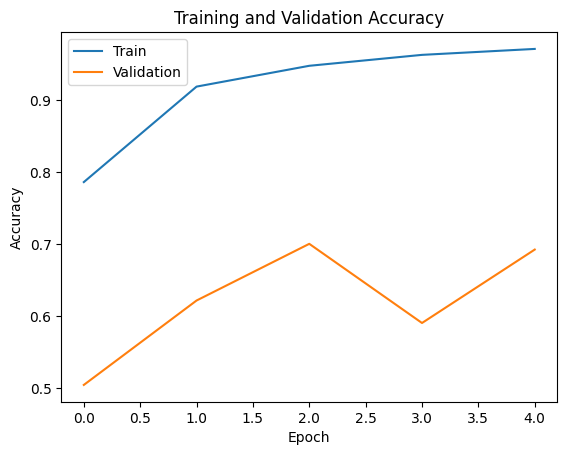

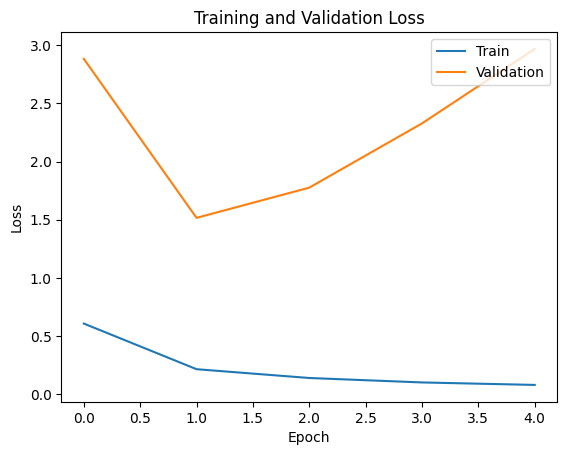

In [9]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

Evaluate the model

In [10]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the annotations test file into a DataFrame
df = pd.read_csv(annotations_test_file)
# Load and preprocess the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=test_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

Found 1954 validated image filenames belonging to 4 classes.
62/62 [==============================] - 90s 1s/step - loss: 1.6766 - accuracy: 0.7677
Test loss: 1.6766
Test accuracy: 0.7677


In [14]:
model_path = r'C:\Users\User\Downloads\Acne Dataset\model_mobilenetv2_V5.h5'
model.save(model_path)